In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

pd.set_option('display.max_columns', None)

import os
import requests
import pytz

from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Use APIs and automatically add missing lines to the original data

In [2]:
original_data=pd.read_csv("processed_data.csv")
original_data=original_data.head(round(len(original_data)*.90))
original_data

,timestamp,btc_open,btc_close,btc_volume,btc_number_of_trades,eth_open,eth_close,eth_volume,eth_number_of_trades,djia_open,djia_close,djia_volume,ixic_open,ixic_close,ixic_volume
0,1.502930e+12,4285.08,4108.37,1199.888264,5233,302.00,293.96,9537.84646,5658,21984.740230,21750.730470,311030000.0,6322.720210,6221.910160,2.041220e+09
1,1.503010e+12,4108.37,4139.98,381.309763,2153,293.31,290.91,2146.19773,1795,21724.880860,21674.509770,309070000.0,6222.459960,6216.529790,1.964590e+09
2,1.503100e+12,4120.98,4086.29,467.083022,2321,289.41,299.10,2510.13871,2038,21707.040370,21684.256510,298673333.3,6220.413247,6215.396487,1.835083e+09
3,1.503190e+12,4069.13,4016.00,691.743060,3972,299.10,323.29,5219.44542,3925,21689.199870,21694.003260,288276666.7,6218.366533,6214.263183,1.705577e+09
4,1.503270e+12,4016.00,4040.00,966.684858,6494,321.04,309.80,7956.35088,6577,21671.359380,21703.750000,277880000.0,6216.319820,6213.129880,1.576070e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,1.670026e+12,16885.20,17105.70,178619.133870,3948990,1240.50,1279.41,324129.54660,498321,34288.876303,34268.953127,298040000.0,11332.583330,11387.646810,4.518683e+09
1941,1.670112e+12,17106.65,16966.35,233703.292250,5138207,1279.40,1259.41,391628.51660,612914,34312.303387,34108.027343,305500000.0,11356.786780,11313.793620,4.514357e+09
1942,1.670198e+12,16966.35,17088.96,218730.768830,4416864,1259.41,1271.32,301631.83900,471097,34335.730470,33947.101560,312960000.0,11380.990230,11239.940430,4.510030e+09
1943,1.670285e+12,17088.96,16836.64,220657.413340,4284989,1271.31,1231.18,398559.51660,530298,33936.871090,33596.339840,306220000.0,11228.419920,11014.889650,4.713330e+09


In [3]:
last_date_dt = pd.to_datetime(original_data['timestamp'].max(), unit='ms') - pd.Timedelta(days=4)
last_date = last_date_dt.strftime('%Y/%m/%d')
day = last_date_dt.day
month = last_date_dt.month
year = last_date_dt.year

In [4]:
"""IMPORT APIs and Cleaning them"""

## Define API key and base URL
apikey = "df09c92f24574a5f9cd8d361f0b58424"
base_url = "https://api.twelvedata.com"

# Define start and end dates
start_date = last_date
end_date = datetime.date.today().strftime("%Y-%m-%d")

## Get NASDAQ data
symbol_nasdaq = "IXIC"
interval_nasdaq = "1day"
url_nasdaq = f"{base_url}/time_series?symbol={symbol_nasdaq}&interval={interval_nasdaq}&start_date={start_date}&end_date={end_date}&apikey={apikey}"
response_nasdaq = requests.get(url_nasdaq)
data_nasdaq = response_nasdaq.json()
df_nasdaq = pd.DataFrame.from_dict(data_nasdaq['values'])
df_nasdaq['datetime'] = pd.to_datetime(df_nasdaq['datetime'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('US/Eastern')
df_nasdaq.set_index('datetime', inplace=True)

## Get DJIA data
symbol_djia = "DJI"
interval_djia = "1day"
url_djia = f"{base_url}/time_series?symbol={symbol_djia}&interval={interval_djia}&start_date={start_date}&end_date={end_date}&apikey={apikey}"
response_djia = requests.get(url_djia)
data_djia = response_djia.json()
df_djia = pd.DataFrame.from_dict(data_djia['values'])
df_djia['datetime'] = pd.to_datetime(df_djia['datetime'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('US/Eastern')
df_djia.set_index('datetime', inplace=True)

df_nasdaq = df_nasdaq.reset_index().rename(columns={'datetime': 'DateTime'})
df_djia = df_djia.reset_index().rename(columns={'datetime': 'DateTime'})

## Define API endpoint and parameters
base_url = "https://api.binance.com/api/v3/klines"
symbol_eth = "ETHUSDT"
symbol_btc = "BTCUSDT"
interval = "1d"

start_date = datetime.datetime(year, month, day)
end_date = start_date + datetime.timedelta(days=500)

## Convert dates to timestamps
t1 = int(start_date.timestamp() * 1000)
t2 = int(end_date.timestamp() * 1000)

## Get ETH data
url_eth = f"{base_url}?symbol={symbol_eth}&interval={interval}&startTime={t1}&endTime={t2}"
response_eth = requests.get(url_eth)
data_eth = response_eth.json()
df_eth = pd.DataFrame(data_eth, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df_eth['timestamp'] = pd.to_datetime(df_eth['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df_eth.set_index('timestamp', inplace=True)

## Get BTC data
url_btc = f"{base_url}?symbol={symbol_btc}&interval={interval}&startTime={t1}&endTime={t2}"
response_btc = requests.get(url_btc)
data_btc = response_btc.json()
df_btc = pd.DataFrame(data_btc, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df_btc.set_index('timestamp', inplace=True)

## Rename timestamp column
df_btc = df_btc.reset_index().rename(columns={'timestamp': 'DateTime'})
df_eth = df_eth.reset_index().rename(columns={'timestamp': 'DateTime'})

## Adding Timestamp format and fixing datetime format
df_btc['DateTime'] = pd.to_datetime(df_btc['DateTime']).dt.date.astype(str)
df_btc['timestamp'] = (pd.to_datetime(df_btc['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_eth['DateTime'] = pd.to_datetime(df_eth['DateTime']).dt.date.astype(str)
df_eth['timestamp'] = (pd.to_datetime(df_eth['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_nasdaq['DateTime'] = pd.to_datetime(df_nasdaq['DateTime']).dt.date.astype(str)
df_nasdaq['timestamp'] = (pd.to_datetime(df_nasdaq['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_djia['DateTime'] = pd.to_datetime(df_djia['DateTime']).dt.date.astype(str)
df_djia['timestamp'] = (pd.to_datetime(df_djia['DateTime'], utc=True).astype(int) / 10**6).astype(float)

## adding a prefix to identify columns easier
new_cols = {}
for col in df_nasdaq.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "ixic_" + col
    else:
        new_cols[col] = col
df_nasdaq = df_nasdaq.rename(columns=new_cols)


new_cols = {}
for col in df_djia.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "djia_" + col
    else:
        new_cols[col] = col
df_djia = df_djia.rename(columns=new_cols)

new_cols = {}
for col in df_btc.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "btc_" + col
    else:
        new_cols[col] = col
df_btc = df_btc.rename(columns=new_cols)

new_cols = {}
for col in df_eth.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "eth_" + col
    else:
        new_cols[col] = col
df_eth = df_eth.rename(columns=new_cols)

dfs = [df_btc, df_eth, df_djia, df_nasdaq]
updated_data = dfs[0]
for df in dfs[1:]:
    updated_data = pd.merge(updated_data, df, on=["timestamp", "DateTime"], how="left")
    
    
# Convert numeric columns to numeric data types
numeric_cols = ['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume', 'btc_quote_asset_volume', 'btc_taker_buy_base_asset_volume', 'btc_taker_buy_quote_asset_volume', 'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume', 'eth_quote_asset_volume', 'eth_taker_buy_base_asset_volume', 'eth_taker_buy_quote_asset_volume', 'djia_open', 'djia_high', 'djia_low', 'djia_close', 'djia_volume', 'ixic_open', 'ixic_high', 'ixic_low', 'ixic_close', 'ixic_volume']
updated_data[numeric_cols] = updated_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert DateTime column to datetime data type
updated_data['DateTime'] = pd.to_datetime(updated_data['DateTime'], format='%Y-%m-%d')

updated_data['DateTime'] = pd.to_datetime(updated_data['DateTime'])
updated_data = updated_data.set_index('DateTime')

# Fill missing values using non-weekend days only
updated_data = updated_data.interpolate(method='time', limit_direction='both', limit=None)

updated_data=updated_data[["timestamp","btc_open","btc_close","btc_volume","btc_number_of_trades","eth_open","eth_close","eth_volume","eth_number_of_trades","djia_open","djia_close","djia_volume","ixic_open","ixic_close","ixic_volume"]]                           
updated_data=updated_data.reset_index(drop=True)


In [5]:
ready_data = pd.concat([original_data, updated_data]).drop_duplicates(subset=['timestamp']).reset_index(drop=True)

In [6]:
ready_data.tail(10)
ready_data.to_csv("processed_data.csv", index=False)

# Run Model Again

In [7]:
ready_data["btc_close_shifted"]=ready_data["btc_close"].shift(-1)
ready_data=ready_data.dropna()
ready_data["btc_number_of_trades"]=pd.to_numeric(ready_data["btc_number_of_trades"])
ready_data["eth_number_of_trades"]=pd.to_numeric(ready_data["eth_number_of_trades"])
ready_data.dtypes

timestamp               float64
btc_open                float64
btc_close               float64
btc_volume              float64
btc_number_of_trades      int64
eth_open                float64
eth_close               float64
eth_volume              float64
eth_number_of_trades      int64
djia_open               float64
djia_close              float64
djia_volume             float64
ixic_open               float64
ixic_close              float64
ixic_volume             float64
btc_close_shifted       float64
dtype: object

In [8]:
X = ready_data.drop('btc_close_shifted', axis=1)
y = ready_data['btc_close_shifted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

# create a XGBoost Regression object
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# fit the model on the training data
model.fit(X_train, y_train)

# predict on the test data
y_pred_xgb = model.predict(X_test)

# evaluate the model using various metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
ev_xgb = explained_variance_score(y_test, y_pred_xgb)

# print the results
print("XGBoost Regression r2:", r2_xgb)
print("XGBoost Regression MAE:", mae_xgb)
print("XGBoost Regression RMSE:", rmse_xgb)
print("XGBoost Regression EV:", ev_xgb)

XGBoost Regression r2: 0.9943223062416684
XGBoost Regression MAE: 637.5595331620066
XGBoost Regression RMSE: 1170.6476945269828
XGBoost Regression EV: 0.9943304759301688


# Update Data to Run New Model

In [10]:
original_data=pd.read_csv("processed_data.csv")
original_data=original_data.head(round(len(original_data)*.90))
original_data

,timestamp,btc_open,btc_close,btc_volume,btc_number_of_trades,eth_open,eth_close,eth_volume,eth_number_of_trades,djia_open,djia_close,djia_volume,ixic_open,ixic_close,ixic_volume
0,1.502930e+12,4285.08,4108.37,1199.888264,5233,302.00,293.96,9537.84646,5658,21984.74023,21750.73047,311030000.0,6322.720210,6221.910160,2.041220e+09
1,1.503010e+12,4108.37,4139.98,381.309763,2153,293.31,290.91,2146.19773,1795,21724.88086,21674.50977,309070000.0,6222.459960,6216.529790,1.964590e+09
2,1.503100e+12,4120.98,4086.29,467.083022,2321,289.41,299.10,2510.13871,2038,21707.04037,21684.25651,298673333.3,6220.413247,6215.396487,1.835083e+09
3,1.503190e+12,4069.13,4016.00,691.743060,3972,299.10,323.29,5219.44542,3925,21689.19987,21694.00326,288276666.7,6218.366533,6214.263183,1.705577e+09
4,1.503270e+12,4016.00,4040.00,966.684858,6494,321.04,309.80,7956.35088,6577,21671.35938,21703.75000,277880000.0,6216.319820,6213.129880,1.576070e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,1.686528e+12,25905.20,25934.25,41065.608530,1007138,1742.57,1740.12,284268.00180,498880,33906.80078,34066.32812,308130000.0,13326.370120,13461.919920,4.722680e+09
2132,1.686614e+12,25934.24,25128.60,45077.316080,957418,1740.12,1650.95,415847.32700,572996,34111.07812,34212.12109,308790000.0,13566.530270,13573.320310,5.522100e+09
2133,1.686701e+12,25128.60,25598.49,48664.860630,943268,1650.95,1666.96,370774.76960,458568,34044.69922,33979.32812,354910000.0,13570.559570,13626.480470,5.772550e+09
2134,1.686787e+12,25598.49,26345.00,51596.916620,926194,1666.96,1717.92,311734.59040,408176,33945.98047,34408.05859,361400000.0,13572.879880,13782.820310,5.667520e+09


In [11]:
last_date_dt = pd.to_datetime(original_data['timestamp'].max(), unit='ms') - pd.Timedelta(days=4)
last_date = last_date_dt.strftime('%Y/%m/%d')
day = last_date_dt.day
month = last_date_dt.month
year = last_date_dt.year

In [12]:
"""IMPORT APIs and Cleaning them"""

## Define API key and base URL
apikey = "df09c92f24574a5f9cd8d361f0b58424"
base_url = "https://api.twelvedata.com"

# Define start and end dates
start_date = last_date
end_date = datetime.date.today().strftime("%Y-%m-%d")

## Get NASDAQ data
symbol_nasdaq = "IXIC"
interval_nasdaq = "1day"
url_nasdaq = f"{base_url}/time_series?symbol={symbol_nasdaq}&interval={interval_nasdaq}&start_date={start_date}&end_date={end_date}&apikey={apikey}"
response_nasdaq = requests.get(url_nasdaq)
data_nasdaq = response_nasdaq.json()
df_nasdaq = pd.DataFrame.from_dict(data_nasdaq['values'])
df_nasdaq['datetime'] = pd.to_datetime(df_nasdaq['datetime'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('US/Eastern')
df_nasdaq.set_index('datetime', inplace=True)

## Get DJIA data
symbol_djia = "DJI"
interval_djia = "1day"
url_djia = f"{base_url}/time_series?symbol={symbol_djia}&interval={interval_djia}&start_date={start_date}&end_date={end_date}&apikey={apikey}"
response_djia = requests.get(url_djia)
data_djia = response_djia.json()
df_djia = pd.DataFrame.from_dict(data_djia['values'])
df_djia['datetime'] = pd.to_datetime(df_djia['datetime'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('US/Eastern')
df_djia.set_index('datetime', inplace=True)

df_nasdaq = df_nasdaq.reset_index().rename(columns={'datetime': 'DateTime'})
df_djia = df_djia.reset_index().rename(columns={'datetime': 'DateTime'})

## Define API endpoint and parameters
base_url = "https://api.binance.com/api/v3/klines"
symbol_eth = "ETHUSDT"
symbol_btc = "BTCUSDT"
interval = "1d"

start_date = datetime.datetime(year, month, day)
end_date = start_date + datetime.timedelta(days=500)

## Convert dates to timestamps
t1 = int(start_date.timestamp() * 1000)
t2 = int(end_date.timestamp() * 1000)

## Get ETH data
url_eth = f"{base_url}?symbol={symbol_eth}&interval={interval}&startTime={t1}&endTime={t2}"
response_eth = requests.get(url_eth)
data_eth = response_eth.json()
df_eth = pd.DataFrame(data_eth, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df_eth['timestamp'] = pd.to_datetime(df_eth['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df_eth.set_index('timestamp', inplace=True)

## Get BTC data
url_btc = f"{base_url}?symbol={symbol_btc}&interval={interval}&startTime={t1}&endTime={t2}"
response_btc = requests.get(url_btc)
data_btc = response_btc.json()
df_btc = pd.DataFrame(data_btc, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df_btc.set_index('timestamp', inplace=True)

## Rename timestamp column
df_btc = df_btc.reset_index().rename(columns={'timestamp': 'DateTime'})
df_eth = df_eth.reset_index().rename(columns={'timestamp': 'DateTime'})

## Adding Timestamp format and fixing datetime format
df_btc['DateTime'] = pd.to_datetime(df_btc['DateTime']).dt.date.astype(str)
df_btc['timestamp'] = (pd.to_datetime(df_btc['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_eth['DateTime'] = pd.to_datetime(df_eth['DateTime']).dt.date.astype(str)
df_eth['timestamp'] = (pd.to_datetime(df_eth['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_nasdaq['DateTime'] = pd.to_datetime(df_nasdaq['DateTime']).dt.date.astype(str)
df_nasdaq['timestamp'] = (pd.to_datetime(df_nasdaq['DateTime'], utc=True).astype(int) / 10**6).astype(float)
df_djia['DateTime'] = pd.to_datetime(df_djia['DateTime']).dt.date.astype(str)
df_djia['timestamp'] = (pd.to_datetime(df_djia['DateTime'], utc=True).astype(int) / 10**6).astype(float)

## adding a prefix to identify columns easier
new_cols = {}
for col in df_nasdaq.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "ixic_" + col
    else:
        new_cols[col] = col
df_nasdaq = df_nasdaq.rename(columns=new_cols)


new_cols = {}
for col in df_djia.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "djia_" + col
    else:
        new_cols[col] = col
df_djia = df_djia.rename(columns=new_cols)

new_cols = {}
for col in df_btc.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "btc_" + col
    else:
        new_cols[col] = col
df_btc = df_btc.rename(columns=new_cols)

new_cols = {}
for col in df_eth.columns:
    if col not in ["DateTime", "timestamp"]:
        new_cols[col] = "eth_" + col
    else:
        new_cols[col] = col
df_eth = df_eth.rename(columns=new_cols)

dfs = [df_btc, df_eth, df_djia, df_nasdaq]
updated_data = dfs[0]
for df in dfs[1:]:
    updated_data = pd.merge(updated_data, df, on=["timestamp", "DateTime"], how="left")
    
    
# Convert numeric columns to numeric data types
numeric_cols = ['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume', 'btc_quote_asset_volume', 'btc_taker_buy_base_asset_volume', 'btc_taker_buy_quote_asset_volume', 'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume', 'eth_quote_asset_volume', 'eth_taker_buy_base_asset_volume', 'eth_taker_buy_quote_asset_volume', 'djia_open', 'djia_high', 'djia_low', 'djia_close', 'djia_volume', 'ixic_open', 'ixic_high', 'ixic_low', 'ixic_close', 'ixic_volume']
updated_data[numeric_cols] = updated_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert DateTime column to datetime data type
updated_data['DateTime'] = pd.to_datetime(updated_data['DateTime'], format='%Y-%m-%d')

updated_data['DateTime'] = pd.to_datetime(updated_data['DateTime'])
updated_data = updated_data.set_index('DateTime')

# Fill missing values using non-weekend days only
updated_data = updated_data.interpolate(method='time', limit_direction='both', limit=None)

updated_data=updated_data[["timestamp","btc_open","btc_close","btc_volume","btc_number_of_trades","eth_open","eth_close","eth_volume","eth_number_of_trades","djia_open","djia_close","djia_volume","ixic_open","ixic_close","ixic_volume"]]                           
updated_data=updated_data.reset_index(drop=True)

In [13]:
ready_data = pd.concat([original_data, updated_data]).drop_duplicates(subset=['timestamp']).reset_index(drop=True)
ready_data["btc_number_of_trades"]=pd.to_numeric(ready_data["btc_number_of_trades"])
ready_data["eth_number_of_trades"]=pd.to_numeric(ready_data["eth_number_of_trades"])

In [14]:
ready_data.tail(10)

,timestamp,btc_open,btc_close,btc_volume,btc_number_of_trades,eth_open,eth_close,eth_volume,eth_number_of_trades,djia_open,djia_close,djia_volume,ixic_open,ixic_close,ixic_volume
2363,1.706573e+12,42941.10,42580.00,39871.13688,1499559,2343.00,2283.14,397116.1859,922884,38298.230470,38467.308590,3.266400e+08,15604.08008,15509.900390,4.719240e+09
2364,1.706659e+12,42580.00,43082.94,35231.04664,1392269,2283.15,2304.28,310997.4538,779472,38426.781250,38150.300780,4.532500e+08,15324.19043,15164.009770,5.875610e+09
2365,1.706746e+12,43082.95,43200.00,29672.14418,1086342,2304.28,2309.06,238230.5110,574621,38175.339840,38519.839840,3.218300e+08,15254.01953,15361.639650,5.046920e+09
2366,1.706832e+12,43199.99,43011.09,12033.40998,609962,2309.07,2296.49,133232.8450,397464,38448.101560,38654.421880,3.797600e+08,15403.16016,15628.950200,4.800690e+09
2367,1.706918e+12,43011.10,42582.88,17066.89404,931235,2296.50,2289.79,171232.0444,506684,38480.990883,38562.988283,3.606033e+08,15473.43685,15618.526697,4.810800e+09
2368,1.707005e+12,42582.88,42708.70,29467.75905,1317397,2289.79,2301.83,236610.4120,730863,38513.880207,38471.554687,3.414467e+08,15543.71354,15608.103193,4.820910e+09
2369,1.707091e+12,42708.70,43098.95,24675.85433,1120760,2301.84,2372.64,368942.7498,861796,38546.769530,38380.121090,3.222900e+08,15613.99023,15597.679690,4.831020e+09
2370,1.707178e+12,43098.96,44349.60,34392.59915,1378809,2372.63,2425.10,342791.7013,860357,38392.898440,38521.359380,2.761400e+08,15638.19043,15609.000000,4.759640e+09
2371,1.707264e+12,44349.60,45288.65,45439.62231,1863650,2425.09,2419.55,338040.0539,894102,38613.890620,38677.359380,3.022100e+08,15690.34961,15756.639650,4.567580e+09
2372,1.707350e+12,45288.66,47265.87,51892.60919,1685030,2419.56,2485.46,367762.3792,834910,38702.109380,38726.328120,3.155100e+08,15762.23047,15793.709960,5.675850e+09


# Apply the Model

In [15]:
y_pred = model.predict(ready_data)

In [16]:
predictions = pd.DataFrame(y_pred, columns=["predicted_value"])


In [17]:
analysis = pd.concat([ready_data[["timestamp", "btc_close"]], predictions], axis=1)
#analysis["date"]=pd.to_datetime(analysis["timestamp"],unit="ms").dt.strftime('%d/%m/%Y')
analysis["date"] = pd.to_datetime(analysis["timestamp"], unit="ms")+ pd.Timedelta(hours=24)
analysis["date"] = analysis["date"].dt.strftime('%d/%m/%Y')
analysis= analysis.drop("timestamp",axis=1)
analysis["btc_close_shifted"]=analysis["btc_close"].shift(-1)

In [18]:
analysis=analysis[["date","btc_close","btc_close_shifted","predicted_value"]]
analysis

,date,btc_close,btc_close_shifted,predicted_value
0,18/08/2017,4108.37,4139.98,4187.922363
1,18/08/2017,4139.98,4086.29,4117.574219
2,19/08/2017,4086.29,4016.00,4049.064941
3,21/08/2017,4016.00,4040.00,4060.867676
4,21/08/2017,4040.00,4114.01,4122.365234
...,...,...,...,...
2368,05/02/2024,42708.70,43098.95,43016.984375
2369,06/02/2024,43098.95,44349.60,43890.152344
2370,07/02/2024,44349.60,45288.65,45053.582031
2371,08/02/2024,45288.65,47265.87,46824.386719


In [19]:
analysis.to_excel('raw_data.xlsx', index=False)

# Additional: Check Metrics Based on Variations, not Actual Values

In [20]:
metrics=analysis
metrics["real_dif"]=(metrics["btc_close_shifted"]/metrics["btc_close"])-1
metrics["predicted_dif"]=(metrics["predicted_value"]/metrics["btc_close"])-1
metrics=metrics.dropna()
metrics.head()

,date,btc_close,btc_close_shifted,predicted_value,real_dif,predicted_dif
0,18/08/2017,4108.37,4139.98,4187.922363,0.007694,0.019363
1,18/08/2017,4139.98,4086.29,4117.574219,-0.012969,-0.005412
2,19/08/2017,4086.29,4016.00,4049.064941,-0.017201,-0.009110
3,21/08/2017,4016.00,4040.00,4060.867676,0.005976,0.011172
4,21/08/2017,4040.00,4114.01,4122.365234,0.018319,0.020387


In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
r2 = r2_score(metrics["real_dif"], metrics["predicted_dif"])
mae = mean_absolute_error(metrics["real_dif"], metrics["predicted_dif"])
rmse = mean_squared_error(metrics["real_dif"], metrics["predicted_dif"], squared=False)
ev = explained_variance_score(metrics["real_dif"], metrics["predicted_dif"])

print("R2 score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("Explained variance score:", ev)


R2 score: 0.5084946042409915
MAE: 0.017439290247091135
RMSE: 0.026883415225458722
Explained variance score: 0.5084970083192716


In [22]:
upper_limit = .02
lower_limit = -.015

In [23]:
metrics["real_inv"] = metrics["real_dif"].apply(lambda x: 1 if x > upper_limit else (-1 if x < lower_limit else 0))
metrics["pred_inv"] = metrics["predicted_dif"].apply(lambda x: 1 if x > upper_limit else (-1 if x < lower_limit else 0))

In [24]:
metrics

,date,btc_close,btc_close_shifted,predicted_value,real_dif,predicted_dif,real_inv,pred_inv
0,18/08/2017,4108.37,4139.98,4187.922363,0.007694,0.019363,0,0
1,18/08/2017,4139.98,4086.29,4117.574219,-0.012969,-0.005412,0,0
2,19/08/2017,4086.29,4016.00,4049.064941,-0.017201,-0.009110,-1,0
3,21/08/2017,4016.00,4040.00,4060.867676,0.005976,0.011172,0,0
4,21/08/2017,4040.00,4114.01,4122.365234,0.018319,0.020387,0,1
...,...,...,...,...,...,...,...,...
2367,04/02/2024,42582.88,42708.70,42448.308594,0.002955,-0.003160,0,0
2368,05/02/2024,42708.70,43098.95,43016.984375,0.009137,0.007218,0,0
2369,06/02/2024,43098.95,44349.60,43890.152344,0.029018,0.018358,1,0
2370,07/02/2024,44349.60,45288.65,45053.582031,0.021174,0.015873,1,0


In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
r2 = r2_score(metrics["real_inv"], metrics["pred_inv"])
mae = mean_absolute_error(metrics["real_inv"], metrics["pred_inv"])
rmse = mean_squared_error(metrics["real_inv"], metrics["pred_inv"], squared=False)
ev = explained_variance_score(metrics["real_inv"], metrics["pred_inv"])

print("R2 score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("Explained variance score:", ev)

R2 score: 0.2309134393896315
MAE: 0.32757166947723443
RMSE: 0.5996766976068136
Explained variance score: 0.2323278359011164


In [26]:
metrics.to_excel('metrics.xlsx', index=False)

# Append Instruction to Model

In [27]:
instruction = analysis[['date', 'btc_close', 'btc_close_shifted', 'predicted_value']]
instruction["pred_var"]=((instruction["predicted_value"]/instruction["btc_close"])-1)*100

In [28]:
instruction

,date,btc_close,btc_close_shifted,predicted_value,pred_var
0,18/08/2017,4108.37,4139.98,4187.922363,1.936349
1,18/08/2017,4139.98,4086.29,4117.574219,-0.541205
2,19/08/2017,4086.29,4016.00,4049.064941,-0.910974
3,21/08/2017,4016.00,4040.00,4060.867676,1.117223
4,21/08/2017,4040.00,4114.01,4122.365234,2.038743
...,...,...,...,...,...
2368,05/02/2024,42708.70,43098.95,43016.984375,0.721830
2369,06/02/2024,43098.95,44349.60,43890.152344,1.835781
2370,07/02/2024,44349.60,45288.65,45053.582031,1.587347
2371,08/02/2024,45288.65,47265.87,46824.386719,3.390997


In [29]:
instruction["instruction"] = instruction["pred_var"].apply(lambda x: "Invest" if x > upper_limit*100 else ("Sell" if x < lower_limit*100 else 0))

In [30]:
instruction.tail(60)

,date,btc_close,btc_close_shifted,predicted_value,pred_var,instruction
2313,12/12/2023,41492.39,42869.03,42199.441406,1.704051,0
2314,13/12/2023,42869.03,43022.26,43260.550781,0.913295,0
2315,14/12/2023,43022.26,41940.30,42526.894531,-1.151417,0
2316,15/12/2023,41940.30,42278.03,41996.566406,0.134158,0
2317,16/12/2023,42278.03,41374.65,41595.480469,-1.614431,Sell
2318,17/12/2023,41374.65,42657.80,41783.593750,0.988392,0
2319,18/12/2023,42657.80,42275.99,42659.023438,0.002868,0
2320,19/12/2023,42275.99,43668.93,43256.828125,2.320083,Invest
2321,20/12/2023,43668.93,43861.80,43847.011719,0.407800,0
2322,21/12/2023,43861.80,43969.04,43808.347656,-0.121865,0


In [31]:
instruction.to_excel("instruction.xlsx")

In [32]:
last_date = str(instruction.tail(1)["date"]).split()[1]
last_day = str(instruction.tail(1)["instruction"]).split()[1]

In [33]:
if str(last_day) == "0":
    print(f"Keep your current position, waint until {last_date} at 19:00 EST for further instructions.")
elif str(last_day) == "Sell":
    print(f"Strong negative trend predicted (Suggestion: {last_day}), waint until {last_date} at 19:00 EST for further instructions.")
else:
    print(f"Strong positive trend predicted (Suggestion: {last_day}), waint until {last_date} at 19:00 EST for further instructions.")
    

Keep your current position, waint until 09/02/2024 at 19:00 EST for further instructions.


In [34]:


btc_close= str(round(float(str(instruction.tail(1)["btc_close"]).split()[1])))
btc_expected= str(round(float(str(instruction.tail(1)["predicted_value"]).split()[1])))

In [35]:
btc_close

'47266'

In [36]:
btc_expected

'47593'

In [37]:
url = 'https://api.binance.com/api/v3/ticker/price'
params = {'symbol': 'BTCUSDT'}
response = requests.get(url, params=params)
data = response.json()
btc_price = float(data['price'])


In [38]:
btc_price

47265.88

In [39]:
btc_close = instruction.iloc[-2][1]

In [40]:
btc_close

45288.65

In [41]:
def continue_check():
    continue_graphing = input("Do you want another graph? (Y/N): ")
    

Input the number of days you want to graph:100


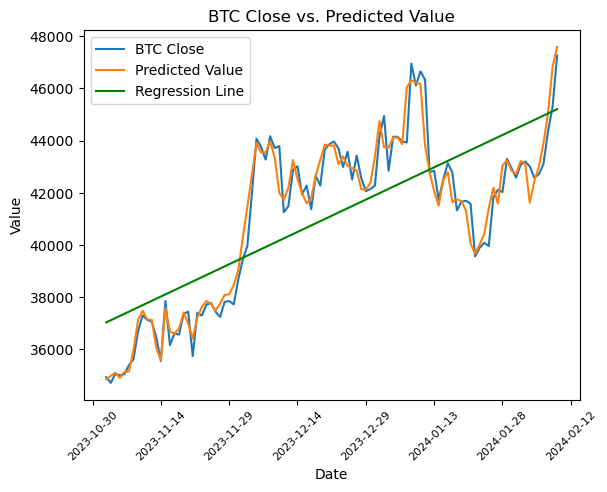

Do you want another graph? (Y/N):N


In [42]:
continue_graphing = "Y"

while continue_graphing == "Y":
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    prev_days = input("Input the number of days you want to graph:")

    date = instruction['date'].tail(int(prev_days))
    btc_close = instruction['btc_close'].tail(int(prev_days))
    predicted_value = instruction['predicted_value'].tail(int(prev_days))

    btc_close[np.isnan(btc_close)] = np.nan

    # Convert the date column to datetime if it's not already in datetime format
    date = pd.to_datetime(date, format='%d/%m/%Y')

    # Convert the predicted_value column to numeric values
    predicted_value_numeric = predicted_value.values

    # Calculate the coefficients of the regression line
    coefficients = np.polyfit(date.index, predicted_value_numeric, 1)
    m, b = coefficients

    fig, ax = plt.subplots()

    # Plot the BTC Close and Predicted Value lines
    ax.plot(date, btc_close, label='BTC Close')
    ax.plot(date, predicted_value, label='Predicted Value')

    # Plot the regression line in green
    ax.plot(date, m * date.index + b, color='green', label='Regression Line')

    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title('BTC Close vs. Predicted Value')
    ax.legend()
    ax.xaxis.set_tick_params(rotation=45, labelsize=8)
    ax.xaxis.set_major_locator(MaxNLocator(10))

    plt.show()
    
    continue_graphing = input("Do you want another graph? (Y/N):")
    